In [491]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [492]:
DATASET_PATH = "data/train_airbnb_berlin.csv"

In [493]:
# Read the raw data
raw_data = pd.read_csv(DATASET_PATH)
raw_data.head(10)

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0
5,26590915.0,*,90250336.0,Zan,2016-08-22,within an hour,100%,t,Mariendorf,Tempelhof - SchÃ¶neberg,...,99.0,10.0,9.0,10.0,10.0,10.0,10.0,t,f,39.0
6,32996974.0,*,5947005.0,Meler,2013-03-13,within a day,80%,f,Wilmersdorf,Charlottenburg-Wilm.,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,94.0
7,17364275.0,*,19435959.0,Alise,2015-04-30,within an hour,100%,f,Kreuzberg,Friedrichshain-Kreuzberg,...,94.0,9.0,9.0,10.0,10.0,10.0,10.0,t,f,73.0
8,23775462.0,*,151814038.0,Ologfi,2017-09-11,NaN,NaN,f,Kreuzberg,Friedrichshain-Kreuzberg,...,93.0,9.0,10.0,9.0,9.0,10.0,9.0,f,f,100.0
9,13483316.0,*,72266241.0,Aselgiiud,2016-05-06,within an hour,100%,f,Moabit,Mitte,...,100.0,10.0,9.0,10.0,10.0,9.0,10.0,f,f,50.0


In [494]:
# Keep only the useful features
columns_to_keep = [
    "Host Since",
    "Host Response Time",
    "Host Response Rate",
    "Is Superhost",
    "neighbourhood",
    "Neighborhood Group",
    "Postal Code",
    "Property Type",
    "Room Type",
    "Accomodates",
    "Bathrooms",
    "Bedrooms",
    "Beds",
    "Guests Included",
    "Min Nights",
    "Reviews",
    "Overall Rating",
    "Accuracy Rating",
    "Cleanliness Rating",
    "Checkin Rating",
    "Communication Rating",
    "Location Rating",
    "Value Rating",
    "Instant Bookable",
    "Business Travel Ready",
    "Price",
]

kept_data = raw_data[columns_to_keep]
kept_data.columns

Index(['Host Since', 'Host Response Time', 'Host Response Rate',
       'Is Superhost', 'neighbourhood', 'Neighborhood Group', 'Postal Code',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating',
       'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating',
       'Communication Rating', 'Location Rating', 'Value Rating',
       'Instant Bookable', 'Business Travel Ready', 'Price'],
      dtype='object')

In [495]:
# Replace '*' with NaN

nan_data = kept_data.replace("*", np.nan)

In [496]:
# Remove rows with NaN prices
priced_data = nan_data.dropna(subset=["Price"])

In [497]:
# One hot encoding for categorical features

def to_one_hot(data:pd.DataFrame, columns:list) -> pd.DataFrame:
    """
    Convert the given columns to one hot encoding
    The original columns are dropped and the new ones should be named according to the category they represent

    :param data: The data to convert
    :param columns: The columns to convert

    :return: The converted data
    """
    for column in columns:
        one_hot = pd.get_dummies(data[column], prefix=column)
        data = data.drop(column, axis=1)
        data = data.join(one_hot)
    return data

categorical_columns = ["Host Response Time", "Property Type", "Room Type"]

one_hot_data = to_one_hot(priced_data, categorical_columns)
one_hot_data.columns

Index(['Host Since', 'Host Response Rate', 'Is Superhost', 'neighbourhood',
       'Neighborhood Group', 'Postal Code', 'Accomodates', 'Bathrooms',
       'Bedrooms', 'Beds', 'Guests Included', 'Min Nights', 'Reviews',
       'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Instant Bookable', 'Business Travel Ready', 'Price',
       'Host Response Time_a few days or more',
       'Host Response Time_within a day',
       'Host Response Time_within a few hours',
       'Host Response Time_within an hour', 'Property Type_Apartment',
       'Property Type_Bed and breakfast', 'Property Type_Boat',
       'Property Type_Boutique hotel', 'Property Type_Bungalow',
       'Property Type_Condominium', 'Property Type_Guest suite',
       'Property Type_Guesthouse', 'Property Type_Hostel',
       'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft',
       'Property Type_Other', 'Pr

In [498]:
# Convert numerical columns to float


def to_int(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Convert the given columns to float

    :param data: The data to convert
    :param columns: The columns to convert

    :return: The converted data
    """
    for column in columns:
        # Replace '*' and '' with NaN
        data[column] = data[column].replace("*", np.nan)
        data[column] = data[column].replace("", np.nan)
        # Convert to float
        data[column] = data[column].astype(float)
    return data


numerical_columns = [
    "Postal Code",
    "Accomodates",
    "Bathrooms",
    "Bedrooms",
    "Beds",
    "Guests Included",
    "Min Nights",
    "Overall Rating",
    "Accuracy Rating",
    "Cleanliness Rating",
    "Checkin Rating",
    "Communication Rating",
    "Location Rating",
    "Value Rating",
]

int_data = to_int(one_hot_data, numerical_columns)
int_data[numerical_columns].head()

,Postal Code,Accomodates,Bathrooms,Bedrooms,Beds,Guests Included,Min Nights,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating
0,10437.0,2.0,1.0,1.0,1.0,1.0,2.0,100.0,10.0,10.0,10.0,10.0,9.0,10.0
1,13187.0,2.0,1.0,2.0,2.0,2.0,7.0,90.0,9.0,9.0,10.0,10.0,9.0,10.0
2,10439.0,3.0,1.0,1.0,2.0,1.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0
3,10245.0,2.0,1.0,1.0,1.0,1.0,2.0,100.0,10.0,10.0,10.0,10.0,10.0,9.0
4,10405.0,3.0,1.0,1.0,2.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [499]:
# Convert Host Response Rate Percentage to float

no_percentage_data = int_data.copy()
no_percentage_data = no_percentage_data.replace("%", "", regex=True)
no_percentage_data = no_percentage_data.replace("*", np.nan)
no_percentage_data["Host Response Rate"] = no_percentage_data["Host Response Rate"].astype(float)
no_percentage_data["Host Response Rate"]

0          NaN
1          NaN
2          NaN
3          NaN
4         92.0
         ...  
15687     33.0
15688      NaN
15689      NaN
15690     50.0
15691    100.0
Name: Host Response Rate, Length: 15683, dtype: float64

In [500]:
# Convert 't' and 'f' to 1 and 0

bool_columns = ["Is Superhost", "Instant Bookable", "Business Travel Ready"]

bool_data = no_percentage_data.copy()
for column in bool_columns:
    bool_data[column] = bool_data[column].replace("t", 1)
    bool_data[column] = bool_data[column].replace("f", 0)
bool_data[bool_columns].head()

,Is Superhost,Instant Bookable,Business Travel Ready
0,0.0,1,0
1,0.0,0,0
2,0.0,0,0
3,0.0,0,0
4,1.0,1,0


In [501]:
# Convert date to number of days to 2022-01-01

date_data = bool_data.copy()
date_data["Host Since"] = pd.to_datetime(date_data["Host Since"])
date_data["Host Since"] = date_data["Host Since"].apply(lambda x: (datetime(2022, 1, 1) - x).days)
date_data["Host Since"]

0        2173.0
1        3191.0
2        2155.0
3        1285.0
4        3152.0
          ...  
15687    3115.0
15688    2449.0
15689    1969.0
15690    2218.0
15691    1608.0
Name: Host Since, Length: 15683, dtype: float64

In [502]:
# Replace '*' in Postal Code with NaN

postal_code_data = date_data.copy()
postal_code_data["Postal Code"] = postal_code_data["Postal Code"].replace("*", np.nan)
postal_code_data["Postal Code"]

0        10437.0
1        13187.0
2        10439.0
3        10245.0
4        10405.0
          ...   
15687    10961.0
15688    12055.0
15689    13351.0
15690    12159.0
15691    10315.0
Name: Postal Code, Length: 15683, dtype: float64

In [503]:
# End of data cleaning

cleaned_data = postal_code_data.copy()

In [504]:
# Train Test Split

X = cleaned_data.copy()
y = cleaned_data["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [505]:
# Create local prices features

local_columns = ["neighbourhood", "Neighborhood Group", "Postal Code"]

def local_prices(X_train, X_test, y_train, y_test, columns):
    """
    Create local prices features for the given columns
    For example:
        For the Kreuzberg value in the neighbourhood column, the local price is the mean price of all the listings in Kreuzberg
        Create a new column named "Local Price neighbourhood" and fill it with the local price for each row
        Calculate local prices using train only and apply it to train and test

    :param X_train: The training data
    :param X_test: The test data
    :param y_train: The training labels
    :param y_test: The test labels
    :param columns: The columns to create local prices features for

    :return: The training and test data with the local prices features
    """
    for column in columns:
        # Create the local price column name
        local_price_column = "Local Price " + column
        # Calculate the local prices
        local_prices = X_train.groupby(column)["Price"].mean()
        # Apply the local prices to train and test
        X_train[local_price_column] = X_train[column].map(local_prices)
        X_test[local_price_column] = X_test[column].map(local_prices)
        # Drop the original column
        X_train = X_train.drop(column, axis=1)
        X_test = X_test.drop(column, axis=1)
    return X_train, X_test

X_train, X_test = local_prices(X_train, X_test, y_train, y_test, local_columns)
X_train["Local Price Neighborhood Group"]

2755     50.333002
8633     50.333002
14197    68.811834
14613    51.630058
8727     68.811834
           ...    
5194     68.811834
13426    50.333002
5393     65.177789
860      55.330544
7274     56.150000
Name: Local Price Neighborhood Group, Length: 12546, dtype: float64

In [506]:
# Drop Price column

X_train = X_train.drop("Price", axis=1)
X_test = X_test.drop("Price", axis=1)

In [507]:
# Find column names that are duplicates

def find_duplicates(data: pd.DataFrame) -> list:
    """
    Find the columns that are duplicates

    :param data: The data to find duplicates in

    :return: The list of duplicate columns
    """
    # Get the column names
    columns = data.columns
    # Get the duplicated columns
    duplicates = data.columns[data.columns.duplicated()]
    # Return the list of duplicates
    return list(duplicates)

print(find_duplicates(X_train))

[]


In [508]:
# Train an XGBRegressor

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

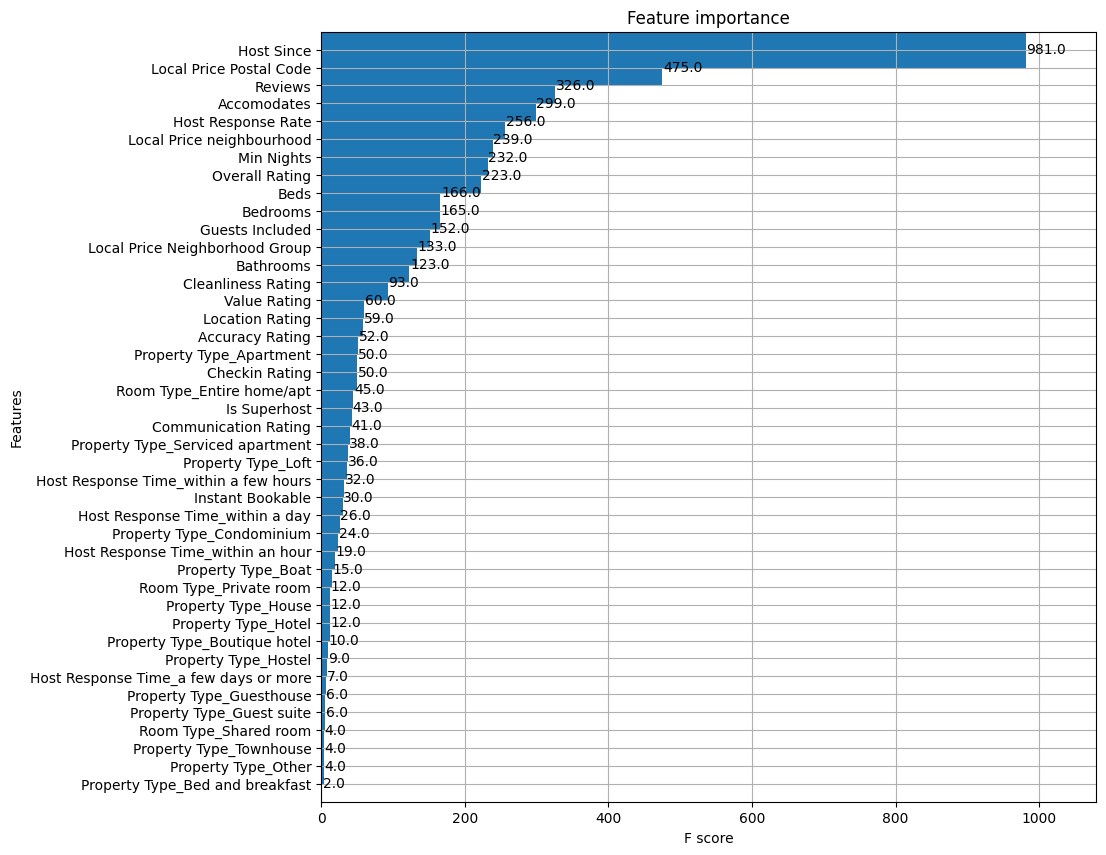

In [509]:
# Print feature importance

# Create a ax
fig, ax = plt.subplots(figsize=(10, 10))

xgb.plot_importance(xgb_model, ax=ax, height=2)

In [510]:
# Print MSE

def mean_absolute_error(y_true, y_pred):
    """
    Print the mean absolute error in euros and in percentage

    :param y_true: The true labels
    :param y_pred: The predicted labels
    """
    mse = np.mean(np.abs(y_true - y_pred))
    print(f"Mean Absolute Error: {round(mse,1):.2f}€")

In [511]:
# Predict on test data

y_pred = xgb_model.predict(X_test)

print("XGBRegressor Performance:") 
mean_absolute_error(y_test, y_pred)

Mean Absolute Error: 21.60€


In [512]:
# Benchmark using a constant model using the average price of y_train

y_pred_benchmark = np.full(y_test.shape, np.mean(y_train))

print("Constant Benchmark Performance:") 
mean_absolute_error(y_test, y_pred_benchmark)

Mean Absolute Error: 30.50€
